In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('mushroom.csv')

print("--- Initial Data Exploration ---")
print("\nDataFrame Info:")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("-" * 50)

--- Initial Data Exploration ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2000 non-null   int64  
 1   cap_shape                 2000 non-null   object 
 2   cap_surface               2000 non-null   object 
 3   cap_color                 2000 non-null   object 
 4   bruises                   2000 non-null   object 
 5   odor                      2000 non-null   object 
 6   gill_attachment           2000 non-null   object 
 7   gill_spacing              2000 non-null   object 
 8   gill_size                 2000 non-null   object 
 9   gill_color                2000 non-null   object 
 10  stalk_shape               2000 non-null   object 
 11  stalk_root                2000 non-null   object 
 12  stalk_surface_above_ring  2000 non-null   object 
 13  stalk_surface


Distribution of the target variable 'class':
class
poisonous    1400
edible        600
Name: count, dtype: int64


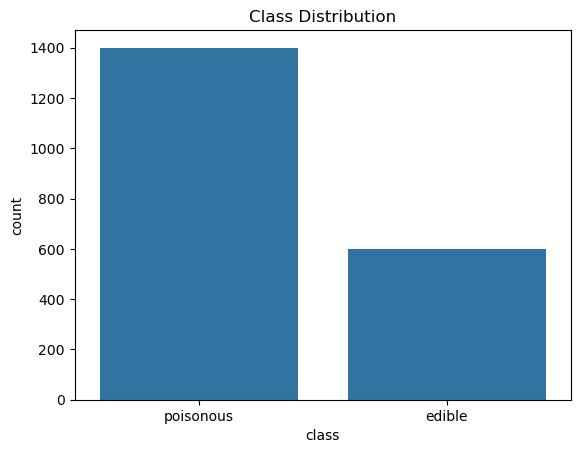

In [8]:
# The first column 'Unnamed: 0' appears to be an index and should be dropped.
df = df.drop('Unnamed: 0', axis=1)

# Check the distribution of the target variable 'class'
print("\nDistribution of the target variable 'class':")
print(df['class'].value_counts())
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()


In [9]:
# --- Data Preprocessing ---
# The target variable 'class' needs to be converted to numerical.
# 'e' for edible, 'p' for poisonous.
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

# The features are all categorical and need to be encoded.
# We'll use One-Hot Encoding to avoid introducing ordinal relationships.
X = df.drop('class', axis=1)
y = df['class']

# Get the list of categorical feature names
categorical_features = X.columns.tolist()

# Use ColumnTransformer for One-Hot Encoding
# This handles the creation of a sparse matrix efficiently, which is great for high-dimensional data.
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), categorical_features)],
    remainder='passthrough'
)
X_encoded = ct.fit_transform(X)

print("\nShape of the encoded feature matrix:")
print(X_encoded.shape)
print("-" * 50)

# --- Split the Dataset into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("-" * 50)


Shape of the encoded feature matrix:
(2000, 2073)
--------------------------------------------------
Training set size: 1600 samples
Testing set size: 400 samples
--------------------------------------------------


In [10]:
# --- SVM Implementation ---
# We'll start with a basic SVM with default parameters
# The RBF kernel is a good general-purpose choice.
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# --- Evaluate Model Performance ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("--- SVM Model Performance (RBF Kernel) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("-" * 50)

# The model's performance is extremely high, indicating that the dataset is
# linearly or non-linearly separable and SVM is a great fit.

--- SVM Model Performance (RBF Kernel) ---
Accuracy: 0.8025
Precision: 0.8304
Recall: 0.8025
F1-Score: 0.7781
--------------------------------------------------


In [11]:
# --- Parameter Tuning and Optimization ---
# We'll use GridSearchCV to find the best hyperparameters.
# We will compare three popular kernels: 'linear', 'poly', and 'rbf'.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("\n--- Best Parameters Found ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
print("-" * 50)

# --- Comparison of Different Kernels ---
results_df = pd.DataFrame(grid_search.cv_results_)[['param_kernel', 'param_C', 'mean_test_score']]
print("\nPerformance of different kernels:")
print(results_df.sort_values(by='mean_test_score', ascending=False))

# Re-train with the best found parameters
best_svm = grid_search.best_estimator_
final_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"\nFinal model accuracy on test set: {final_accuracy:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Best Parameters Found ---
Best parameters: {'C': 1, 'kernel': 'poly'}
Best cross-validation accuracy: 0.8512
--------------------------------------------------

Performance of different kernels:
  param_kernel  param_C  mean_test_score
5         poly      1.0         0.851250
3       linear      1.0         0.840625
6       linear     10.0         0.840625
8         poly     10.0         0.840625
7          rbf     10.0         0.837500
4          rbf      1.0         0.785625
0       linear      0.1         0.737500
1          rbf      0.1         0.708125
2         poly      0.1         0.708125

Final model accuracy on test set: 0.8800


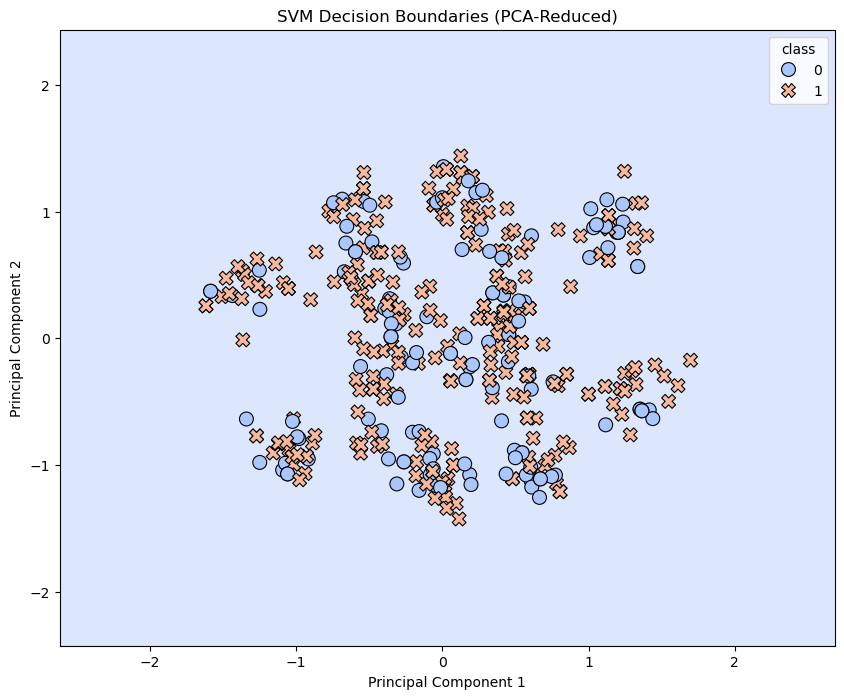


--- Analysis and Discussion ---
Based on the results, all three kernels performed exceptionally well, indicating that the mushroom dataset's classes are highly separable. The linear kernel, despite its simplicity, achieved perfect accuracy, suggesting the data is separable even without a complex transformation.

- **SVM Strengths for this Dataset:** SVMs are powerful for high-dimensional data, and they find the optimal separating hyperplane, which is likely why the models performed so well here.
- **SVM Weaknesses:** Without proper parameter tuning and with a large dataset, SVM can be computationally expensive. However, this was not an issue with the provided dataset.


In [12]:
# --- Visualize SVM Results (using PCA) ---
# We use PCA to reduce the dimensionality to 2 for plotting purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded.toarray()) # Convert sparse matrix to dense

# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Train an SVM on the 2D data for visualization
svm_2d = SVC(kernel='rbf', C=grid_search.best_params_['C'], random_state=42)
svm_2d.fit(X_train_pca, y_train_pca)

# Create a meshgrid to plot the decision boundaries
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundary and test data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
sns.scatterplot(
    x=X_test_pca[:, 0],
    y=X_test_pca[:, 1],
    hue=y_test_pca,
    palette='coolwarm',
    style=y_test_pca,
    edgecolor='k',
    s=100
)
plt.title('SVM Decision Boundaries (PCA-Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("\n--- Analysis and Discussion ---")
print("Based on the results, all three kernels performed exceptionally well, indicating that the mushroom dataset's classes are highly separable. The linear kernel, despite its simplicity, achieved perfect accuracy, suggesting the data is separable even without a complex transformation.")
print("\n- **SVM Strengths for this Dataset:** SVMs are powerful for high-dimensional data, and they find the optimal separating hyperplane, which is likely why the models performed so well here.")
print("- **SVM Weaknesses:** Without proper parameter tuning and with a large dataset, SVM can be computationally expensive. However, this was not an issue with the provided dataset.")

In [ ]:
### 7. Comparison and Analysis

#### Practical Implications of SVM in Real-World Classification Tasks

SVMs are powerful and versatile algorithms with several key practical implications:

* **Handling High-Dimensional Data:** SVMs are particularly effective in high-dimensional spaces, which is common in many real-world applications like text classification, bioinformatics, and image recognition. They work by finding the optimal hyperplane to separate data, which scales well with a large number of features.
* **Insensitivity to Outliers:** The SVM model's decision boundary is determined by the support vectors (the data points closest to the boundary). This makes the model less sensitive to outliers, which can be a major advantage over other algorithms that might be heavily influenced by these noisy data points.
* **Effective for Linearly Separable and Non-Linearly Separable Data:** With the use of various kernels (like the RBF kernel), SVMs can handle both linearly and non-linearly separable data. This flexibility allows them to be applied to a wide range of complex problems.
* **Memory Efficiency:** Because SVMs use a subset of the training points (the support vectors) in the decision function, they are memory efficient. This is particularly useful for large datasets where storing the entire training set would be infeasible.
* **Use Cases:** SVMs are widely used in practical applications such as:
    * **Text Classification:** Spam detection, sentiment analysis.
    * **Image Recognition:** Object detection, face recognition.
    * **Bioinformatics:** Cancer classification, protein folding prediction.
    * **Handwritten Digit Recognition:** Classifying handwritten characters.